In [1]:
using DataFrames
using CSV
using ControlSystemsBase
using Statistics
using Distributions
using Plots
using GLM
using Serialization
using OffsetArrays

using RealTimeScheduling
using ControlTimingSafety

push!(LOAD_PATH, "../lib")
using Experiments
using Benchmarks
using ControlVariates

@info Threads.nthreads()

[ Info: 1


## Generate Samples

### Setting Parameters

In [2]:
B = 4.15e5
H = 100
q = 0.99
period = 0.02
sys = benchmarks[:F1T]
x0 = 1.
u0 = 0.
z0 = [fill(x0, size(sys.A, 1)); u0]

# Construct an automaton with no constraint
a = hold_kill(c2d(sys, period), delay_lqr(sys, period))

Automaton(AbstractMatrix{Float64}[[1.0 0.12999999999999998 0.02559055118110236; 0.0 1.0 0.39370078740157477; -0.582977923541146 -0.9271753376618662 -0.3501109341069651], [1.0 0.12999999999999998 0.02559055118110236; 0.0 1.0 0.39370078740157477; 0.0 0.0 1.0]], Union{Missing, Int64}[1 1], Union{Missing, Int64}[1 2], 1, [1.0 0.0 0.0])

### System Dynamics


Open-loop stable system (RC network):
$$
\mathbf{\dot{x}}(t) = \begin{bmatrix} -6.0 & 1.0 \\ 0.2 & -0.7 \end{bmatrix} \mathbf{x}(t) +
\begin{bmatrix} 5.0 \\ 0.5 \end{bmatrix} u(t)
$$
where
$$
\mathbf{x}(t) = \begin{bmatrix} x_1(t) \\ x_2(t) \end{bmatrix}
$$
is the system state and $u(t)$ is the control input.

We also have a open-loop unstable system (F1 tenth):
$$
\mathbf{\dot{x}}(t) = \begin{bmatrix} 0 & 6.5 \\ 0 & 0 \end{bmatrix} \mathbf{x}(t) +
\begin{bmatrix} 0 \\ 19.685 \end{bmatrix} u(t)
$$

In [ ]:
benchmarks[:RCN], benchmarks[:F1T]

### Simulations

We first sample sequences of length H=100 where each deadline has p=0.9 chance to hit.

In [ ]:
sp = SamplerPWCET(0.9, 100)
mean([sum(rand(sp)) for i in 1:100])

Generate 100k samples:

In [ ]:
n = 100_000
@time res99 = generate_samples(a, z0, 0.99, n)
@time res90 = generate_samples(a, z0, 0.90, n)
@time res50 = generate_samples(a, z0, 0.50, n)
@time res10 = generate_samples(a, z0, 0.10, n)

Save samples to disk

In [ ]:
using Serialization
@time serialize("../data/res99-100k.jls", res99)
@time serialize("../data/res90-100k.jls", res90)
@time serialize("../data/res50-100k.jls", res50)
@time serialize("../data/res10-100k.jls", res10)

### Analyze Simulated Samples

In [3]:
suffix = "1000000"
res99 = deserialize("../data/res99-$suffix.jls")
res90 = deserialize("../data/res90-$suffix.jls")
res50 = deserialize("../data/res50-$suffix.jls")
res10 = deserialize("../data/res10-$suffix.jls");

Generate plots of deviation versus control variables for the first 7 periods.

1000000


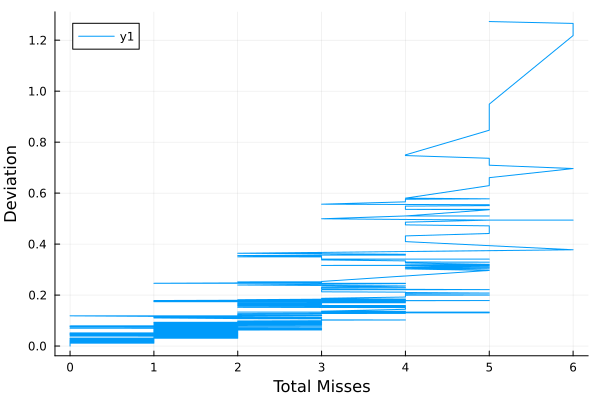

In [8]:
res = res90
devs = map(x -> x[2], res)
σs = map(x -> x[1], res)
σs3 = map(x -> x[1:3], σs)
σs5 = map(x -> x[1:5], σs)
σs7 = map(x -> x[1:7], σs)
σsx = map(x -> x[1:10], σs)

p1 = plot(devs, (1:length(res)) ./ length(res), 
    xlabel="Deviation", ylabel="Probability", label="cdf", title="p=0.10")
p2 = plot(missrow.(σs7), devs,
    ylabel="Deviation", xlabel="Consecutive Misses", label="p=0.9")
p3 = plot(misstotal.(σs7), devs,
    ylabel="Deviation", xlabel="Total Misses")
p4 = plot(missfirst.(σs7), devs,
    ylabel="Deviation", xlabel="First Miss")
for c in [0.99]
    dev = devs[round(Int64, length(res)*c)]
    scatter!(p1, [dev], [c], label="99th quantile = $(round(dev, sigdigits=3))")
end
println(length(res))
savefig(p1, "cdf.pdf")
savefig(p2, "cv_cm_7.pdf")
savefig(p3, "cv_tm_7.pdf")
savefig(p4, "cv_fm_7.pdf")
display(p3)

Print results for 99% and 100% quantile in each sample, along with the ratio between two quantiles.

In [5]:
for (res, p) in [(res99, 0.99), (res90, 0.9), (res50, 0.5), (res10, 0.1)]
    devs = map(x -> x[2], res)
    p99 = round(devs[round(Int64, length(devs)*0.99)], sigdigits=3)
    p100 = round(devs[end], sigdigits=3)
    println("p=$p\t99%=$p99\t100%=$p100\tp100/p99=$(p100/p99)")
end

p=0.99	99%=0.165	100%=0.364	p100/p99=2.206060606060606
p=0.9	99%=0.331	100%=1.27	p100/p99=3.836858006042296
p=0.5	99%=1.66	100%=18.6	p100/p99=11.204819277108435
p=0.1	99%=36300.0	100%=198000.0	p100/p99=5.454545454545454


## Quantile Estimation

### Naive Monte Carlo

#### Confidence Interval Calculation

Assume sample size is $N$ and $ξ$ is the quantile we want to estimate. Then $B_{n,p} \equiv n \hat{F}_{NMC,n} (ξ) = \sum_{i=1}^n I(Y_i \leq ξ)$ has a binomial $(n, p)$ distribution.

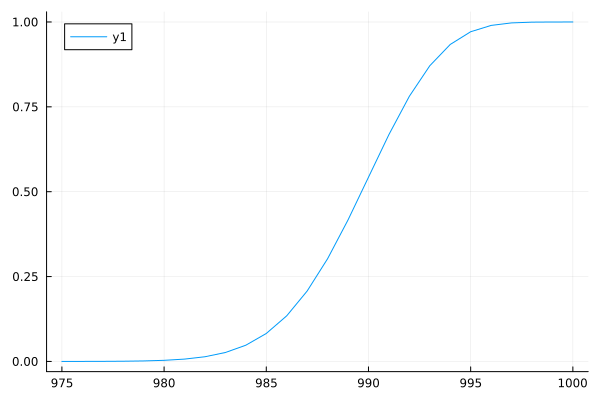

In [3]:
# Sample size
n = 1000
# We are interested in the 99th quantile
p = 0.99

# Get the binomial distribution for B(n, p)
dist = Binomial(n, p)

# Visualizing the CDF of B(n, p)
x = 975:1000
plot(x, cdf(dist, x))

In [4]:
# Find intervals with >0.95 probability mass
intervals = find_intervals(100000, p, 0.05)

21-element Vector{Any}:
 (98880, 99051)
 (98914, 99052)
 (98921, 99053)
 (98925, 99054)
 (98928, 99055)
 (98931, 99056)
 (98933, 99057)
 (98934, 99058)
 (98936, 99059)
 (98937, 99060)
 (98938, 99061)
 (98939, 99062)
 (98940, 99063)
 (98941, 99064)
 (98942, 99066)
 (98943, 99067)
 (98944, 99070)
 (98945, 99072)
 (98946, 99076)
 (98947, 99081)
 (98948, 99092)

In [8]:
# Verify that the first and last intervals are the limits.
dist_test = Binomial(100000, p)
@info cdf(dist_test, 99050)
@info cdf(dist_test, 98947)

[ Info: 0.9466733983488915
[ Info: 0.04850136369885568


In [12]:
data = deserialize("../data/nmc/b0.1m-q0.99-th16.jls")
@info data[Integer(100000*p)][2]
for intv in intervals
    i1, i2 = intv
    @info (intv, data[i1][2], data[i2][2])
end

[ Info: 0.169773126785829
[ Info: ((98880, 99051), 0.05375018292835406, 0.1786396896500381)
[ Info: ((98914, 99052), 0.06687005679248492, 0.1786396896500381)
[ Info: ((98921, 99053), 0.06690978903249059, 0.1786396896500381)
[ Info: ((98925, 99054), 0.06690978903249059, 0.1786396896500381)
[ Info: ((98928, 99055), 0.06922455752146969, 0.1786396896500381)
[ Info: ((98931, 99056), 0.06922455752146969, 0.1786396896500381)
[ Info: ((98933, 99057), 0.06922455752146969, 0.1786396896500381)
[ Info: ((98934, 99058), 0.06922455752146969, 0.1786396896500381)
[ Info: ((98936, 99059), 0.06922455752146969, 0.1786396896500381)
[ Info: ((98937, 99060), 0.06922455752146969, 0.1786396896500381)
[ Info: ((98938, 99061), 0.07696874086949579, 0.1786396896500381)
[ Info: ((98939, 99062), 0.07696874086949579, 0.1786396896500381)
[ Info: ((98940, 99063), 0.07696874086949579, 0.1786396896500381)
[ Info: ((98941, 99064), 0.07696874086949579, 0.1786396896500381)
[ Info: ((98942, 99066), 0.07696874086949579, 0.17

**Confidence interval conclusions**

The indices of a confidence interval are determined solely by $n$, $p$ and $\alpha$ values. However, the specific values of the interval is dependent on the task model. Particularly, in our setup it is very dependent on the hit chance of individual deadlines.

#### Comparing NMC with Partitioning using Weakly Hard Constraints

In [2]:
path = "../data/nmc"

tasks = map(Iterators.product([100_000, 1_000_000, 10_000_000], [0.9, 0.99, 0.999])) do (b, q)
    filename = "b$(b/1_000_000)m-q$q-th16"
    Threads.@spawn @time filename => deserialize("$path/$filename.jls")
end
data = Dict(fetch.(tasks))

  0.935243 seconds (8.03 M allocations: 805.051 MiB, 6.64% gc time, 220.74% compilation time)
  0.965404 seconds (8.44 M allocations: 818.762 MiB, 6.43% gc time, 217.24% compilation time)
  1.351143 seconds (8.85 M allocations: 984.837 MiB, 30.00% gc time, 156.48% compilation time)
 13.835202 seconds (78.63 M allocations: 2.995 GiB, 20.83% gc time, 3.95% compilation time)
 15.001626 seconds (82.56 M allocations: 3.607 GiB, 19.62% gc time, 15.40% compilation time)
 16.481531 seconds (88.24 M allocations: 3.619 GiB, 17.62% gc time, 12.56% compilation time)
306.662259 seconds (291.25 M allocations: 11.547 GiB, 19.68% gc time, 0.06% compilation time)
388.378410 seconds (324.75 M allocations: 14.148 GiB, 18.18% gc time, 0.59% compilation time)
393.066594 seconds (333.53 M allocations: 14.282 GiB, 17.96% gc time, 0.53% compilation time)


Dict{String, Vector{Tuple{BitVector, Float64}}} with 9 entries:
  "b0.1m-q0.9-th16"    => [([1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1,…
  "b0.1m-q0.99-th16"   => [([1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1,…
  "b1.0m-q0.99-th16"   => [([1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1,…
  "b1.0m-q0.999-th16"  => [([1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1,…
  "b10.0m-q0.9-th16"   => [([1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1,…
  "b10.0m-q0.99-th16"  => [([1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1,…
  "b10.0m-q0.999-th16" => [([1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1,…
  "b1.0m-q0.9-th16"    => [([1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1,…
  "b0.1m-q0.999-th16"  => [([1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1,…

In [5]:
df_nmc = DataFrame(
    batchsize=Int[],
    q=Float64[], 
    p99lowid=Int[], 
    p99highid=Int[], 
    p99=Float64[], 
    p99low=Float64[], 
    p99high=Float64[], 
    p99_over_p99high=Float64[], 
    time=Float64[])

# 99-th percentile
p = 0.99
# 0.95 Confidence interval
α = 0.05
path = "../data/nmc"

for b in [100_000, 1_000_000, 10_000_000]
    intervals = find_intervals(b, p, α)
    for q in [0.9, 0.99, 0.999]
        filename = "b$(b/1_000_000)m-q$q-th16"
        t = parse(Float64, read("$path/$filename.txt", String))
        p99 = data[filename][Integer(b*p)][2]
        # Choose the first interval that results in the smallest p99high
        i1, i2 = intervals[1]
        push!(df_nmc, (b, q, i1, i2, p99, data[filename][i1][2], data[filename][i2][2], p99/data[filename][i2][2], t))
    end
end
df_nmc

Row,batchsize,q,p99lowid,p99highid,p99,p99low,p99high,p99_over_p99high,time
,Int64,Float64,Int64,Int64,Float64,Float64,Float64,Float64,Float64
1,100000,0.9,98880,99052,0.339582,0.316412,0.341041,0.995723,46.1793
2,100000,0.99,98880,99052,0.169773,0.0537502,0.17864,0.950366,30.6819
3,100000,0.999,98880,99052,0.00198362,0.000973612,0.00198362,1.0,29.2627
4,1000000,0.9,989633,990164,0.330531,0.316412,0.337899,0.978193,163.77
5,1000000,0.99,989633,990164,0.156631,0.0769687,0.169773,0.922591,370.248
6,1000000,0.999,989633,990164,0.00198362,0.00198362,0.00314404,0.630914,294.65
7,10000000,0.9,9898808,9900518,0.334203,0.318694,0.334203,1.0,4339.79
8,10000000,0.99,9898808,9900518,0.133302,0.123298,0.156631,0.851059,4104.13
9,10000000,0.999,9898808,9900518,0.00198362,0.00198362,0.00198362,1.0,2753.32


In [36]:
df_whp = DataFrame(CSV.File("../data/WeaklyHard_data.csv"))

# hit, window, chance of meeting deadline q=[0.9, 0.99, 0.999]
whp = ones(6, 6, 3)
# whp[4,6,2] = 0.9991

for row in eachrow(df_whp)
    if row[1] > 6 continue end
    whp[row[2], row[1], row[3]] = row[4]
end

df_whp

Row,Window,Hit,q,Probability
,Int64,Int64,Int64,Float64
1,1,1,1,2.65614e-5
2,2,1,1,0.401511
3,3,1,1,0.915235
4,3,2,1,0.197473
5,4,1,1,0.991295
6,4,2,1,0.793567
7,4,3,1,0.111307
8,5,1,1,0.999135
9,5,2,1,0.970006


In [40]:
df_whc = DataFrame(
    batchsize=Int[],
    q=Float64[], 
    window=Int[], 
    hit=Int[], 
    p99=Float64[], 
    p99high=Float64[], 
    p99_over_p99high=Float64[])

# 99-th percentile
p = 0.99
# 0.95 Confidence interval
α = 0.05

# [p99, p99high], hit, window, q=[0.9, 0.99, 0.999], b=[100_000, 1_000_000, 10_000_000]
res = zeros(2, 6, 6, 3, 3)

path = "../data/nmc"

b = [100_000, 1_000_000, 10_000_000]
q = [0.9, 0.99, 0.999]
for bi in 1:2, qi in 1:2
    filename = "b$(b[bi]/1_000_000)m-q$(q[qi])-th16"
    t = parse(Float64, read("$path/$filename.txt", String))
    Threads.@threads for i in 1:15
        window, hit = 2, i
        while hit >= window
            hit -= (window - 1)
            window += 1
        end
        c = MeetAny(hit, window)
        if whp[hit, window, qi] < p continue end
        pprime = p / whp[hit, window, qi]
        filtered = filter(pair -> pair[1] ⊢ c, data[filename])
        i1, i2 = find_intervals(length(filtered), pprime, α)[1]
        p99 = round(Int64, length(filtered)*pprime)
        res[1, hit, window, qi, bi] = filtered[p99][2]
        res[2, hit, window, qi, bi] = filtered[i2][2]
    end
end
for bi in 1:2, qi in 1:2, window in 2:6, hit in 1:window-1
    if res[1, hit, window, qi, bi] == 0 continue end
    p99, p99high = res[:, hit, window, qi, bi]
    push!(df_whc, (b[bi], q[qi], window, hit, p99, p99high, p99/p99high))
end
df_whc

Row,batchsize,q,window,hit,p99,p99high,p99_over_p99high
,Int64,Float64,Int64,Int64,Float64,Float64,Float64
1,100000,0.9,4,1,0.364089,0.364089,1.0
2,100000,0.9,5,1,0.341041,0.356913,0.955529
3,100000,0.9,6,1,0.339582,0.341041,0.995723
4,100000,0.9,6,2,0.364089,0.364089,1.0
5,100000,0.99,2,1,0.17864,0.17864,1.0
6,100000,0.99,3,1,0.176587,0.17864,0.988511
7,100000,0.99,4,1,0.169773,0.17864,0.950366
8,100000,0.99,4,2,0.17864,0.17864,1.0
9,100000,0.99,5,1,0.169773,0.17864,0.950366


#### Confidence interval guided NMC

In [2]:
path = "../data/nmc"

# # Multithread data loading-probably uses more memory
# tasks = map(Iterators.product([100_000, 1_000_000, 10_000_000], [0.9, 0.99, 0.999])) do (b, q)
#     filename = "b$(b/1_000_000)m-q$q-th16"
#     Threads.@spawn @time filename => deserialize("$path/$filename.jls")
# end
# data = Dict(fetch.(tasks))

# Single thread loading
# tasks = map(Iterators.product([100_000, 1_000_000, 10_000_000], [0.9, 0.99, 0.999])) do (b, q)
tasks = map(Iterators.product([100_000, 1_000_000], [0.9, 0.99, 0.999])) do (b, q)
    filename = "b$(b/1_000_000)m-q$q-th16"
    @time filename => deserialize("$path/$filename.jls")
end
data = Dict(tasks)

  0.106241 seconds (1.03 M allocations: 47.355 MiB, 18.05% compilation time)
  1.903627 seconds (10.01 M allocations: 411.065 MiB, 21.93% gc time)
  0.111448 seconds (1.00 M allocations: 45.603 MiB)
  1.836483 seconds (10.01 M allocations: 411.063 MiB, 12.32% gc time)
  0.383619 seconds (1.00 M allocations: 45.603 MiB, 77.10% gc time)
  1.802171 seconds (10.01 M allocations: 411.057 MiB, 5.53% gc time)


Dict{String, Vector{Tuple{BitVector, Float64}}} with 6 entries:
  "b0.1m-q0.9-th16"   => [([1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, …
  "b0.1m-q0.99-th16"  => [([1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, …
  "b1.0m-q0.99-th16"  => [([1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, …
  "b1.0m-q0.999-th16" => [([1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, …
  "b1.0m-q0.9-th16"   => [([1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, …
  "b0.1m-q0.999-th16" => [([1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, …

In [22]:
df_incremental_nmc = DataFrame(
    batchsize=Int[],
    q=Float64[], 
    p99lowid=Int[], 
    p99highid=Int[], 
    p99=Float64[], 
    p99low=Float64[], 
    p99high=Float64[], 
    p99_over_p99high=Float64[])

# 99-th percentile
p = 0.99
# 0.95 Confidence interval
α = 0.05

path = "../data/batches"
for q in [0.9, 0.99]
    @time batchdata = deserialize("$path/q=$q.jls")
    @info size(batchdata[1])
    pool = []
    for batch in batchdata
        append!(pool, batch)
        sort!(pool, by=x -> x[2])
        n = length(pool)
        intervals = find_intervals(n, p, α, centered=true)
        p99 = pool[round(Int64, n*p)][2]
        # Choose the first interval that results in the smallest p99high
        i1, i2 = intervals[1]
        push!(df_incremental_nmc, (n, q, i1, i2, p99, pool[i1][2], pool[i2][2], p99/pool[i2][2]))
    end
end

# path = "../data/nmc"
# for b in [100_000, 1_000_000, 10_000_000], current_n in round(Int64, b/10):round(Int64, b/10):b
#     intervals = find_intervals(current_n, p, α, centered=true)
#     for q in [0.9, 0.99, 0.999]
#         filename = "b$(b/1_000_000)m-q$q-th16"
#         t = parse(Float64, read("$path/$filename.txt", String))
#         p99 = data[filename][round(Int64, current_n*p)][2]
#         # Choose the first interval that results in the smallest p99high
#         i1, i2 = intervals[1]
#         push!(df_incremental_nmc, (b, current_n, q, i1, i2, p99, data[filename][i1][2], data[filename][i2][2], p99/data[filename][i2][2], t))
#         break
#     end
# end

df_incremental_nmc

  1.838215 seconds (9.96 M allocations: 411.588 MiB, 7.58% gc time)


[ Info: (10000,)


  2.002897 seconds (9.96 M allocations: 411.615 MiB, 14.18% gc time)


[ Info: (10000,)


Row,batchsize,q,p99lowid,p99highid,p99,p99low,p99high,p99_over_p99high
,Int64,Float64,Int64,Int64,Float64,Float64,Float64,Float64
1,10000,0.9,9879,9918,0.339582,0.18731,0.364089,0.932689
2,20000,0.9,19771,19826,0.339582,0.316412,0.356913,0.951442
3,30000,0.9,29665,29732,0.339582,0.253431,0.341041,0.995723
4,40000,0.9,39559,39638,0.339582,0.316412,0.356913,0.951442
5,50000,0.9,49455,49542,0.341041,0.339582,0.356913,0.955529
6,60000,0.9,59351,59446,0.341041,0.339582,0.356913,0.955529
7,70000,0.9,69247,69350,0.339582,0.337899,0.341041,0.995723
8,80000,0.9,79143,79254,0.339582,0.334203,0.341041,0.995723
9,90000,0.9,89040,89157,0.339582,0.334203,0.341041,0.995723


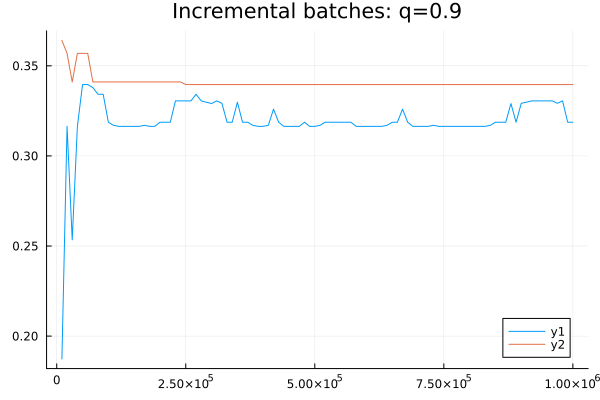

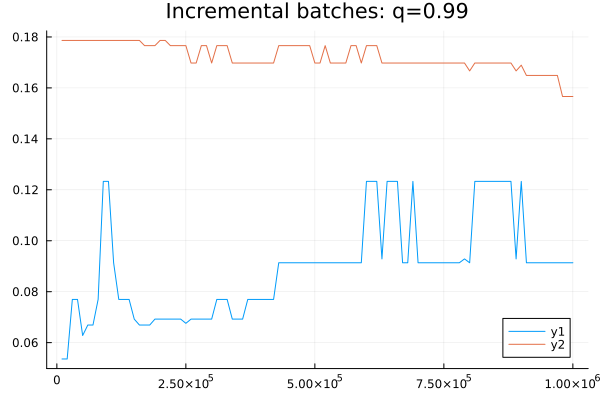

In [40]:
for q in [0.9, 0.99]
    view = filter(:q => isequal(q), df_incremental_nmc)
    display(plot(
        view[!, :batchsize], 
        [view[!, :p99low], view[!, :p99high]],
        title="Incremental batches: q=$q"))
end

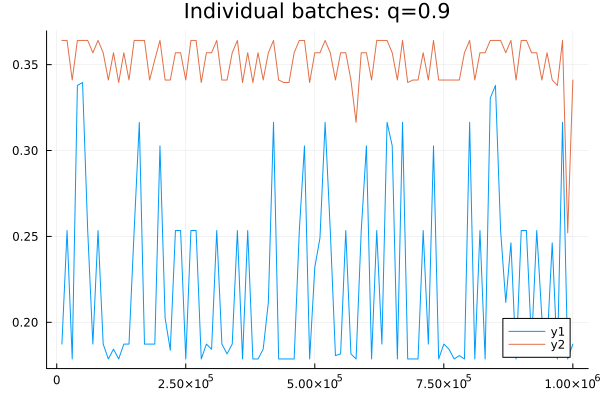

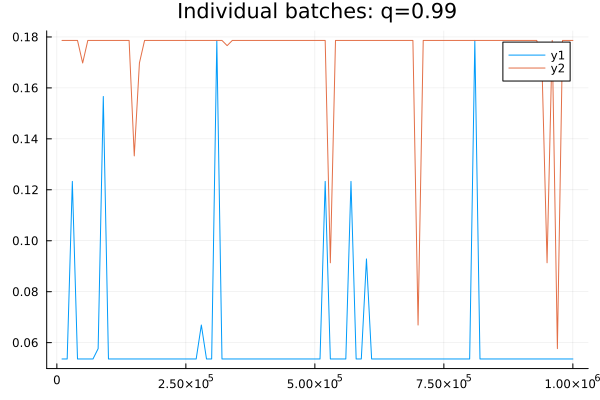

In [41]:
# Control group
path = "../data/batches"
for q in [0.9, 0.99]
    batchdata = deserialize("$path/q=$q.jls")
    n = length(batchdata[1])
    intervals = find_intervals(n, p, α, centered=true)
    counter = 0
    batch_stat = map(batchdata) do batch
        p99 = batch[round(Int64, n*p)][2]
        # Choose the first interval that results in the smallest p99high
        i1, i2 = intervals[1]
        counter += n
        [counter, batch[i1][2], batch[i2][2]]
    end
    bs, lows, highs = map(collect, zip(batch_stat...))
    display(plot(bs, [lows, highs], title="Individual batches: q=$q"))
end

### Statistical Hypothesis Testing

#### How Many Samples?
Questions regarding sample size and prior belief for SHT is discussed in this section. The key points are summarized below:

|   B    | type-I error |   c    |  Original K  |    K    |  Original K / K  |
| ------ | ------------ | ------ | ------------ | ------- | ---------------- |
| 100    | 0.497        | 0.99   | 459.20       | 69.47   | 6.61             |
| 100    | 0.497        | 1-1e-5 | 4.62e5       | 99.95   | 4617.38          |
| 4.15e5 | 0.000238     | 0.99   | 1287.12      | 829.94  | 1.55             |
| 4.15e5 | 0.000238     | 1-1e-5 | 1.2936e6     | 1.639e5 | 7.89             |

**Questions regarding prior belief**

The issue about equal prior belief for $H_0$ and $H_1$: recall that given deviation upper bound $d_{ub}$, confidence level $c$, and the set of all possible samples $X$, the two hypothesis are defined as follows:
$$
\newcommand{\dev}{\texttt{Deviation}}
H_0: Pr(\dev(x) < d_{ub} | x \in X) < c \\
H_1: Pr(\dev(x) < d_{ub} | x \in X) > c
$$
assuming that the sample $x$ is drawn uniformly from the set $X$.
In the SHT paper, the Bayes Factor $B$ is used to compute $K$, the number of required samples to draw to give 

\begin{align}
\frac{Pr(H_1)}{Pr(H_0)} B &= \frac{Pr(H_1|Data)}{Pr(H_0|Data)} \\
\frac{Pr(H_1)}{Pr(H_0)} B &= \frac{\frac{Pr(Data|H_1)Pr(H_1)}{Pr(Data)}}{\frac{Pr(Data|H_0)Pr(H_0)}{Pr(Data)}} \\
B &= \frac{Pr(Data|H_1)}{Pr(Data|H_0)} \\
B &= \frac{\int_c^1 P(Data|\theta=q, H_1) f_{\theta|H_1}(q)dq}
          {\int_0^c P(Data|\theta=q, H_0) f_{\theta|H_0}(q)dq} \\
B &= \frac{\int_c^1 P(Data|\theta=q, H_1) \frac{1}{1-c} dq}
          {\int_0^c P(Data|\theta=q, H_0) \frac{1}{c} dq} \\
B &= \frac{c \int_c^1 q^K dq}
          {(1-c) \int_0^c q^K dq} \\
\frac{1-c}{c} B &= \frac{\int_c^1 q^K dq}
                        {\int_0^c q^K dq} \\
K &= -\log_c(\frac{1-c}{c}B + 1)
\end{align}

A factor of $\frac{1-c}{c}$ is missing from within the logarithm function, and will cause more samples to be drawn than intended.

Traditionally, a Bayes factor $B$ of $100$ is considered extreme evidence favoring the alternative hypothesis. However, the paper we are based on states the type-I error is expressed by
$$
err = \frac{c}{c(1-c)B}
$$
Which is ~$.497$ when $B=100$, and ~$.000238$ when $B=4.15*10^5$:

In [ ]:
let
    c = 0.99
    B = 100
    e = c/(c+(1-c)*B)
    B_og = 4.15e5
    e_og = c/(c+(1-c)*B_og)
    @info "Comparison of error with B=100 versus B=4.15e5: " e e_og
end

Next, we compare the original $K$ values from the paper versus the new $K$ values with the missing factor.

In [ ]:
let
    B = 4.15e5
    c = [0.9, 0.99, 0.999, 0.9999, 1-1e-5, 1-1e-10, 1-1e-15]
    K_og = -log.(c, B + 1)
    K    = -log.(c, (1 .- c) ./ c * B .+ 1)

    [c K_og K K_og./K]
end

Finally we compare the $K$ values with $B=100$

In [ ]:
let
    B = 100
    c = [0.9, 0.99, 0.999, 0.9999, 1-1e-5, 1-1e-10, 1-1e-15]
    K_og = -log.(c, B + 1)
    K    = -log.(c, (1 .- c) ./ c * B .+ 1)

    [c K_og K K_og./K]
end

#### Experiments

Conclusion: min of 50 runs with SHT is close to 99th percentile in large random samples, with lower p values leading to more overestimation compared to 99th percentile; max of 50 runs is closer to 100th percentile, but underestimates.

In [7]:
for p in [0.1, 0.5, 0.9, 0.99]
    mind = Inf
    maxd = 0.
    sample_t = 0
    devest_t = 0
    for i in 1:50
        t = time()
        sp = SamplerPWCET(p, 100)
        sample_t += time() - t
        
        t = time()
        dub = estimate_deviation(a, sp, z0, q, B)
        devest_t += time() - t

        mind = min(mind, dub)
        maxd = max(maxd, dub)
    end
    @info p sample_t devest_t mind maxd maxd/mind
end

┌ Info: 0.1
│   sample_t = 4.76837158203125e-6
│   devest_t = 18.42928910255432
│   mind = 63081.78583606427
│   maxd = 162052.8839993246
└ @ Main /Users/jerry/Projects/pwcet-safety/src/main.ipynb:18
┌ Info: 0.5
│   sample_t = 3.814697265625e-6
│   devest_t = 19.37014889717102
│   mind = 2.4701570944702076
│   maxd = 16.83713655921366
└ @ Main /Users/jerry/Projects/pwcet-safety/src/main.ipynb:18
┌ Info: 0.9
│   sample_t = 5.0067901611328125e-6
│   devest_t = 15.322127342224121
│   mind = 0.36408893924524055
│   maxd = 0.9491345984884901
└ @ Main /Users/jerry/Projects/pwcet-safety/src/main.ipynb:18
┌ Info: 0.99
│   sample_t = 6.198883056640625e-6
│   devest_t = 11.982646465301514
│   mind = 0.1786396896500381
│   maxd = 0.36408893924524055
└ @ Main /Users/jerry/Projects/pwcet-safety/src/main.ipynb:18


### Likelihood Ratio Test

\begin{align}
\lambda_{LR} &=\frac{\sup_{\theta_0\in\Theta_0}{L}(\theta_0)}{\sup_{\theta\in\Theta}L(\theta)} \\
&= \frac{\binom{n}{x} \theta_0^x (1-\theta_0)^{n-x}}{\binom{n}{x} \theta^x (1-\theta)^{n-x}} \\
&= \frac{\theta_0^x (1-\theta_0)^{n-x}}{ \theta^x (1-\theta)^{n-x}} \\
&= \left(\frac{\theta_0}{\theta}\right)^x + \left(\frac{1-\theta_0}{1-\theta}\right)^{n-x}
\end{align}

\begin{align}
&= -2 \ln \left[ \frac{\binom{n}{k} \theta_0^x (1-\theta_0)^{n-x}}{\binom{n}{k} \theta_1^x (1-\theta_1)^{n-x}} \right] \\
&= -2 \ln \left[ \frac{\theta_0^x (1-\theta_0)^{n-x}}{ \theta_1^x (1-\theta_1)^{n-x}} \right] \\
&= -2 (x \ln \frac{\theta_0}{\theta_1} + (n-x) \ln \frac{1-\theta_0}{1-\theta_1})
\end{align}

In [ ]:
lr_test(0.99, 100, 99)

In [ ]:
lr_test(0.99, 830, 830)

In [ ]:
lr_test_2(0.99, 8782, 0.005)

In [ ]:
lr_test_2(0.99, 46500, 0.002)

Likelihood ratio with null hypothesis: true $\theta$ is within a range (e.g., $[0.899, 0.991]$) instead of $\theta>0.99$ vs $\theta<0.99$.

In [ ]:
err = 0.000238497

In [ ]:
n = 8782
for p in [0.99, 0.90, 0.50, 0.10]
    mind = Inf
    maxd = 0.
    devest_t = 0
    for i in 1:50
        t = time()
        lrres = generate_samples(σ p, n)
        x = round(Int64, n * 0.99)
        dev = lrres[x][2]
        devest_t += time() - t
        
        mind = min(mind, dev)
        maxd = max(maxd, dev)
    end
    @info p devest_t mind maxd maxd/mind
end

### Control Variate

#### Analytical Solutions

**First Miss**

The probability $P(n)$ of first miss occurs in position $n$ in a string of length $H (H \ge n)$ with hit probablity $a (0\le a\le1)$ is:
$$
P(n)=a^{n-1}\cdot (1-a)
$$
The mean value of the position of first miss $M(H)$ can be expressed as:
$$
\begin{align}
M(H)&=\sum^{H}_{n=1}nP(n)\\
&=(1-a)\sum^{H}_{n=1}na^{n-1}\\
&=(1-a)\sum^{H}_{n=1}\frac{d}{da}a^n\\
&=(1-a)\frac{d}{da}\sum^{H}_{n=1}a^n\\
&=(1-a)\frac{d}{da}\frac{a(1-a^H)}{1-a}\\
&=\frac{Ha^{H+1}-(H+1)a^H+1}{1-a}
\end{align}
$$

In [ ]:
a = 0.9
H = 100

first_miss_mean = (H*a^(H+1) - (H+1)*a^H + 1) / (1-a)

**Total misses**

The probability $P(n,H)$ of $n$ total misses occurs  in a string of length $H (H \ge n)$ with hit probablity $a (0\le a\le1)$ is:
$$
P(n,H)= {H \choose n}a^{H-n}(1-a)^n
$$
Let $1-a=x$.
The mean value of the total number of misses $M(H)$ can be expressed as:
$$
\begin{align}
M(H)&=\sum^{H}_{n=1}nP(n,H)\\
&=\sum^{H}_{n=1}n{H \choose n}a^{H-n}x^n\\
&=x\sum^{H}_{n=1}\frac{d}{dx}{H \choose n}a^{H-n}x^n\\
&=x\frac{d}{dx}(a+x)^H\\
&=H(1-a)
\end{align}
$$

In [ ]:
a = 0.9
H = 100

total_miss_mean = H*(1-a)

**Consecutive Misses**

We calculate the expected value of # of longest consecutive misses in a sequence by leveraging two matrices with dynamic programming. Assuming each deadline has a chance of $p$ being met,
$$
C[m, k] = P(\text{a sequence of length $m$ has a longest consecutive misses of $k$})
$$ and 
$$
T[m, k] = P(\text{a sequence of length $m$ has a consecutive misses of $k$})
$$
$$
C[m, k] = \sum_{j = 0}^k T[m, j]
$$
Base case 1:
For $k = 0$
$$
\begin{align}
T[m, 0] &= p^m \\
C[m, 0] &= T[m, 0]
\end{align}
$$
Base case 2:
For $k = m$
$$
\begin{align}
T[m, m] &= (1 - p)^m\\
C[m, m] &= 1
\end{align}
$$
Assuming the **first** longest sequence starts at $i$ and has length $j$.There are three cases:

Case 1: longest sequence starts at the first input i.e. $i = 1\\$
$$
T[m, j]_{i=1} = T[j, j]\cdot p \cdot C[m-j-1, j]
$$

Case 2: longest sequence is at the end of the string, since the sequence is at the end, earlier consecutive misses are at most j-1 in length. i.e. $i = m - j + 1\\$
$$
T[m, j]_{i=m-j+1} = T[j, j]\cdot p \cdot C[m-j-1, j]
$$

Case 3:  longest sequence is in the middle of the string i.e. $1 < i < m - j + 1\\$
$$
T[m, j]_{1<i<m-j+1} = C[i-2, j-1] \cdot p \cdot T[j, j] \cdot p \cdot C[m-i-j, j]
$$

As a result
$$
T[m, j] = T[m, j]_{i=1} + T[m, j]_{1<i<m-j+1} + T[m, j]_{i=m-j+1}
$$

Meanwhile
$$
C[m, j] = C[m, j-1] + T[m, j]
$$
Thus, we can obtain then mean of consecutive misses for any given string length $m$ and longest consecutive misses $j$ by induction from base case

In [ ]:
@time T, C = calculate_missrow_prob(10, 0.9)

In [ ]:
T

In [ ]:
sum(map(x -> x*T[10, x], 0:10))

#### Experiments


In [ ]:
function devubrow(miss::Integer, sysd::AbstractStateSpace{<:Discrete},
    K::AbstractMatrix{<:Real}, z_0::AbstractVecOrMat, d_max::Real, n::Integer,
    H::Integer, nominal::Union{Matrix{<:Real}, Nothing}=nothing)
    @boundscheck nominal === nothing || size(nominal, 1) == H+1 || throw(ArgumentError("nominal and H mismatch"))
    if miss === 0 && nominal === nothing
        return 0.
    end
    constraint = MissRow(miss)
    a = hold_kill(sysd, K, constraint)
    reachable = bounded_runs_iter(a, z_0, n, H)
    if size(reachable, 1) != H+1
        @info "Size mismatch"
        return d_max
    end
    # @info "Data" meet window size(reachable, 1) argmax(deviation(a, z_0, reachable))
    maximum(deviation(a, z_0, reachable, nominal_trajectory=nominal))
end


In [ ]:
p = 0.020
ctrlp = 0.020
x_0 = 1.
u_0 = 0.
d_max = 10.
# cs = [0.999, 0.99, 0.9, 0.8, 0.7, 0.5]
maxwindow = 6
n = 15
H = 100

for (name, sys) in pairs(benchmarks)
    print(name, ' ')
    sysd = c2d(sys, p)
    K = delay_lqr(sys, ctrlp)
    z_0 = [fill(x_0, size(sysd.A, 1)); fill(u_0, size(sysd.B, 2))]

    devs = fill(Inf, maxwindow)

    t = time()
    for miss in 1:maxwindow
        devs[miss] = devubrow(miss, sysd, K, z_0, d_max, n, H)
    end
    t = time() - t
    print(round(t, sigdigits=2), ' ')
    display(dev)
end


In [9]:
# Using values from simulation

res = res90
devs = map(x -> x[2], res)
σs = map(x -> x[1], res)
σs5 = map(x -> x[1:10], σs)

X = devs
Y = missrow.(σs)
Y5 = missrow.(σs5)
Z = misstotal.(σs)
Z5 = misstotal.(σs5)
U = missfirst.(σs)

data = DataFrame(Dev=X, CM=Y, TM=Z, FM=U, CM5=Y5, TM5=Z5)

ols_y = lm(@formula(Dev ~ CM5), data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Dev ~ 1 + CM5

Coefficients:
────────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error       t  Pr(>|t|)    Lower 95%    Upper 95%
────────────────────────────────────────────────────────────────────────────────
(Intercept)  -0.00350164  8.08529e-5  -43.31    <1e-99  -0.00366011  -0.00334317
CM5           0.0565896   8.36878e-5  676.20    <1e-99   0.0564256    0.0567536
────────────────────────────────────────────────────────────────────────────────

In [8]:
ols_z = lm(@formula(Dev ~ TM5), data)

UndefVarError: UndefVarError: `data` not defined

In [ ]:
ols_u = lm(@formula(Dev ~ FM), data)

In [ ]:
FcvW(0.1566, 10, res90, misstotal)

In [ ]:
x = inverse_fcv(0.99, 10, res90, misstotal)

In [ ]:
res90[99000][2]

In [ ]:
confidence_interval(0.1, x, 0.01, 0.99, 9.997078246122365, res90, missfirst)

In [ ]:
Psi2_cv(x, 0.99, res50, misstotal)

In [ ]:
calculate_mean_miss(missfirst,res90)

In [ ]:
(100*0.9^101-101*0.9^100+1)/0.1

In [ ]:
x=[1,2,3]
y=x[1:2]

In [ ]:
res = generate_samples(a, z0, 0.9, 1000)
res2 = Vector{Tuple{BitVector, Float64}}(undef, 1000)
i = 1
for(σ, deviation) in res
    σs5 =  σ[1:10]
    res2[i] = (σs5, deviation)
    i += 1
end
i = 1
res2

In [ ]:
dev_CV = inverse_fcv(0.99, 1, res2, misstotal)
dev_NMC = res[990][2]
print(dev_NMC,dev_CV)

In [ ]:
result = Vector{BitVector}(undef, 0)
    previous = [[1],[0]]
    for vector in previous
        push!(vector, 1)
        push!(result, vector)
    end
result

In [14]:
σ5 = map(x -> (x[1][1:5], x[2]), res99)
σ = Dict(
    "5" => map(x -> (x[1][1:5], x[2]), res99)
)
σ["5"]

1000000-element Vector{Tuple{BitVector, Float64}}:
 ([1, 1, 1, 1, 1], 0.0)
 ([1, 1, 1, 1, 1], 0.0)
 ([1, 1, 1, 1, 1], 0.0)
 ([1, 1, 1, 1, 1], 0.0)
 ([1, 1, 1, 1, 1], 0.0)
 ([1, 1, 1, 1, 1], 0.0)
 ([1, 1, 1, 1, 1], 0.0)
 ([1, 1, 1, 1, 1], 0.0)
 ([1, 1, 1, 1, 1], 0.0)
 ([1, 1, 1, 1, 1], 0.0)
 ⋮
 ([0, 0, 1, 1, 1], 0.36408893924524055)
 ([0, 0, 1, 1, 1], 0.36408893924524055)
 ([0, 0, 1, 1, 1], 0.36408893924524055)
 ([0, 0, 1, 1, 1], 0.36408893924524055)
 ([0, 0, 1, 1, 1], 0.36408893924524055)
 ([0, 0, 1, 1, 1], 0.36408893924524055)
 ([0, 0, 1, 1, 1], 0.36408893924524055)
 ([0, 0, 1, 1, 1], 0.36408893924524055)
 ([0, 0, 1, 1, 1], 0.36408893924524055)

In [ ]:
n = bin_list(10)
p = 0.9
values = map(vec -> missrow(vec) * p^(10 - misstotal(vec)) * (1 - p)^misstotal(vec), n)
total = sum(values)

In [ ]:
allmind['missrow'] = 5
for cv in cvs:
    mind = Inf
    maxd = 0
    for sampleset in samplesets:
        qestimate = estimate(cv, sampleset)
        mind = min(mind, qestimate)
        maxd = max(maxd, qestimate)
        @info "CV function: $cv" mind maxd


In [ ]:
p = 0.9
mind_NMC = Inf
maxd_NMC = 0
mind_CV = Inf
maxd_CV = 0
for i in 1:50
    n = 10000
    res = generate_samples(a, z0, p, n)
    res2 = Vector{Tuple{BitVector, Float64}}(undef, n)
    k = 1
    for(σ, deviation) in res
        σs5 =  σ[1:10]
        res2[k] = (σs5, deviation)
        k += 1
    end
    k = 1

    dev_CV = inverse_fcv(0.99, 0.7395658498000013, res2, missrow)
    dev_NMC = res[Int(n*0.99)][2]

    mind_CV = min(mind_CV, dev_CV)
    maxd_CV = max(maxd_CV, dev_CV)
    mind_NMC = min(mind_NMC, dev_NMC)
    maxd_NMC = max(maxd_NMC, dev_NMC)

end
@info p mind_CV maxd_CV mind_NMC maxd_NMC

In [ ]:
p = 0.9
mind_NMC = Inf
maxd_NMC = 0
mind_CV = Inf
maxd_CV = 0
for i in 1:50
    n = 10000
    res = generate_samples(a, z0, p, n)
    res2 = Vector{Tuple{BitVector, Float64}}(undef, n)
    k = 1
    for(σ, deviation) in res
        σs5 =  σ[1:10]
        res2[k] = (σs5, deviation)
        k += 1
    end
    k = 1

    dev_CV = inverse_fcv(0.99, (10*0.9^11-11*0.9^10+1)/0.1, res2, missfirst)

    dev_NMC = res[Int(n*0.99)][2]

    mind_CV = min(mind_CV, dev_CV)
    maxd_CV = max(maxd_CV, dev_CV)
    mind_NMC = min(mind_NMC, dev_NMC)
    maxd_NMC = max(maxd_NMC, dev_NMC)

end
@info p mind_CV maxd_CV mind_NMC maxd_NMC

In [ ]:
p = 0.9
mind_NMC = Inf
maxd_NMC = 0
mind_CV = Inf
maxd_CV = 0
for i in 1:50
    n = 10000
    res = generate_samples(a, z0, p, n)
    res2 = Vector{Tuple{BitVector, Float64}}(undef, n)
    k = 1
    for(σ, deviation) in res
        σs5 =  σ[1:10]
        res2[k] = (σs5, deviation)
        k += 1
    end
    k = 1

    dev_CV = inverse_fcv(0.99, 1, res2, misstotal)

    dev_NMC = res[Int(n*0.99)][2]

    mind_CV = min(mind_CV, dev_CV)
    maxd_CV = max(maxd_CV, dev_CV)
    mind_NMC = min(mind_NMC, dev_NMC)
    maxd_NMC = max(maxd_NMC, dev_NMC)

end
@info p mind_CV maxd_CV mind_NMC maxd_NMC

In [ ]:
p = 0.9
mind_NMC = Inf
maxd_NMC = 0
mind_CV = Inf
maxd_CV = 0
for i in 1:50
    n = 10000
    res = generate_samples(a, z0, p, n)

    dev_CV = inverse_fcv(0.99, (100*0.9^101-101*0.9^100+1)/0.1, res, missfirst)

    dev_NMC = res[Int(n*0.99)][2]

    mind_CV = min(mind_CV, dev_CV)
    maxd_CV = max(maxd_CV, dev_CV)
    mind_NMC = min(mind_NMC, dev_NMC)
    maxd_NMC = max(maxd_NMC, dev_NMC)

end
@info p mind_CV maxd_CV mind_NMC maxd_NMC

In [ ]:
p = 0.9
mind_NMC = Inf
maxd_NMC = 0
mind_CV = Inf
maxd_CV = 0
for i in 1:50
    n = 10000
    res = generate_samples(a, z0, p, n)

    dev_CV = inverse_fcv(0.99, (100*0.9^101-101*0.9^100+1)/0.1, res, missfirst)

    dev_NMC = res[Int(n*0.99)][2]

    mind_CV = min(mind_CV, dev_CV)
    maxd_CV = max(maxd_CV, dev_CV)
    mind_NMC = min(mind_NMC, dev_NMC)
    maxd_NMC = max(maxd_NMC, dev_NMC)

end
@info p mind_CV maxd_CV mind_NMC maxd_NMC

In [ ]:
for p in [0.1, 0.5, 0.9, 0.99]
    mind_NMC = Inf
    maxd_NMC = 0
    mind_CV = Inf
    maxd_CV = 0
    for i in 1:50
        n = 10000
        res = generate_samples(a, z0, p, n)

        dev_CV = inverse_fcv(0.99, 100*(1-p), res, misstotal)

        dev_NMC = res[Int(n*0.99)][2]

        mind_CV = min(mind_CV, dev_CV)
        maxd_CV = max(maxd_CV, dev_CV)
        mind_NMC = min(mind_NMC, dev_NMC)
        maxd_NMC = max(maxd_NMC, dev_NMC)

    end
    @info p mind_CV maxd_CV mind_NMC maxd_NMC
end

## Probability of random run satisfying weakly hard constraints

Assume we have a weakly hard constraint $(m, k)$, and we know individual deadlines has a $p$ chance of being met. What is the probability that a random run of length $H$ will satisfy the weakly hard constraint $(m, k)$.

### One weakly hard constraints

In [3]:
import RealTimeScheduling: MeetAny, satisfies

hit(s::Integer, window::Integer) = (s << 1) & (2^window - 1) | 1
miss(s::Integer, window::Integer) = (s << 1) & (2^window - 1)
satisfies(s::Integer, c::MeetAny) = count_ones(s & (2^c.window - 1)) >= c.meet

using OffsetArrays: Origin, no_offset_view

function get_matrix(meet::Integer, window::Integer, p::Real)
    if meet == window
        return [1 0; 1-p p]
    elseif meet == 0
        return [1 0; 0 1]
    else
        L = 2^window
        T = Origin(0)(zeros(L, L))
        T[0, 0] = 1
        for i = 1:L-1
            # hit
            T[i, hit(i, window)] = p
            # miss
            if satisfies(miss(i, window), MeetAny(meet, window))
                T[i, miss(i, window)] = 1 - p
            else
                T[i, 0] = 1 - p
            end
        end
        return no_offset_view(T)
    end
end

get_matrix(c::MeetAny, p::Real) = get_matrix(c.meet, c.window, p)


get_matrix (generic function with 2 methods)

In [4]:
P = get_matrix(MeetAny(1, 3), 0.9)


8×8 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.1  0.9  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.1  0.9  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.9
 0.1  0.9  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.1  0.9  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.1  0.9  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.9

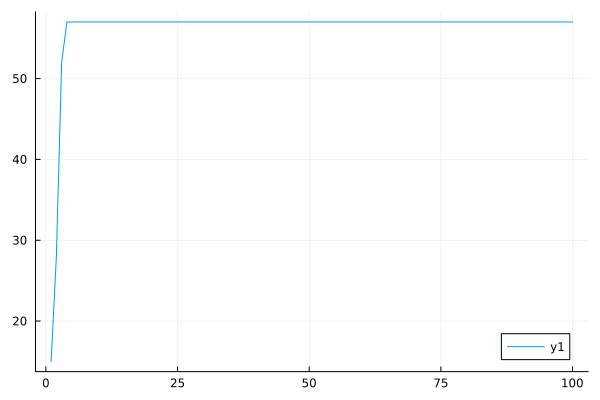

In [5]:
using Plots: plot, plot!
plot(1:100, map(i -> sum(map(x -> x != 0, P^i)), 1:100))


In [5]:
P^100

8×8 Matrix{Float64}:
 1.0        0.0         0.0         …  0.0        0.0        0.0
 0.0847652  0.00744022  0.00818492     0.0743351  0.0743351  0.669016
 0.0930246  0.00737308  0.00811105     0.0736643  0.0736643  0.662978
 0.0847652  0.00744022  0.00818492     0.0743351  0.0743351  0.669016
 0.175545   0.00670225  0.00737308     0.066962   0.066962   0.602658
 0.0847652  0.00744022  0.00818492  …  0.0743351  0.0743351  0.669016
 0.0930246  0.00737308  0.00811105     0.0736643  0.0736643  0.662978
 0.0847652  0.00744022  0.00818492     0.0743351  0.0743351  0.669016

### Probability for random runs satisfying one of multiple weakly hard constraints

In [21]:
import RealTimeScheduling: MeetAny, satisfies, ⊢

bits(n::Integer) = BitVector(digits(n, base=2) |> reverse)
bits_to_int(bv::BitVector) = let 
    s = 0
    v = 1
    for bit in reverse(bv)
        println("$s $bit $v")
        s += v * bit
        v <<= 1
    end
    s
end

hit(s::Integer, window::Integer, constraints::Vector{<:RealTimeScheduling.WeaklyHardConstraint}) = let
    pattern_mask = 2^window - 1
    memory_mask  = 2^length(constraints) - 1
    pattern = (s << 1) & pattern_mask | 1
    memory  = (s >> window) & memory_mask
    return memory << window | window
end
miss(s::Integer, window::Integer,  constraints::Vector{<:RealTimeScheduling.WeaklyHardConstraint}) = let 
    pattern_mask = 2^window - 1
    memory_mask  = 2^length(constraints) - 1
    pattern = (s << 1) & pattern_mask | 1
    memory  = (s >> window) & memory_mask
    memory  = bits_to_int(map((mem, cons) -> Bool(mem & (pattern ⊢ cons)), bits(memory), constraints))
    return (memory << window) | pattern
end

using OffsetArrays: Origin, no_offset_view

function get_matrix(meet::Integer, window::Integer, p::Real)
    if meet == window
        return [1 0; 1-p p]
    elseif meet == 0
        return [1 0; 0 1]
    else
        L = 2^window
        T = Origin(0)(zeros(L, L))
        T[0, 0] = 1
        for i = 1:L-1
            # hit
            T[i, hit(i, window)] = p
            # miss
            if satisfies(miss(i, window), meet, window)
                T[i, miss(i, window)] = 1 - p
            else
                T[i, 0] = 1 - p
            end
        end
        return no_offset_view(T)
    end
end


get_matrix (generic function with 2 methods)

In [22]:
s = bits_to_int(BitVector([1, 0, 0, 1, 1, 0, 1]))


0 true 1
1 false 2
1 true 4
5 true 8
13 false 16
13 false 32
13 true 64


77